<a target="_blank" href="https://colab.research.google.com/github/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/CognitiveModeling.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)  # for nicer-looking plots
import jax.numpy as jnp
import jax
import optax
import scipy

In [2]:
!pip install -U dm-haiku
import haiku as hk
rng_seq = hk.PRNGSequence(np.random.randint(2**32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 6.3 MB/s eta 0:00:00


# Part 1: Human Behavior

In this Colab, we will put to practive what we've learned in today's lecture:
* **We will first train an RL agent to perform a task, using one of the methods we heard about earlier.**
* **After that, we will fit an RL model to a real human dataset, and analyze (fake) fMRI data!**

To get started, let's first load our dataset to get it out of the way. Execute the following cell to load the dataset from gitbub into this Colab.

You will need to download the dataset from the google drive folder and upload it into this notebook using the code below.

*Note: If Option 1 throws an error, please run Option 2 instead.*

In [8]:
# # Option 1
# human_data = pd.read_csv("./bahrami_100.csv")
# # link = 'https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/bahrami_100.csv'
# # human_data = pd.read_csv(link)

# Option 2 (in case option 1 doesn't work)
from google.colab import files
import io
uploaded = files.upload()
human_data = pd.read_csv(io.BytesIO(uploaded['bahrami_100.csv']))

Saving bahrami_100.csv to bahrami_100.csv


Now that we have the dataset, let's take a look at it:

In [9]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036
...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784


The table doesn't tell us much - so let's first understand the task that this dataset is coming from:

We are working with a "4-armed bandit task". The figure below depicts what is happening on each trial of this task from participants' perspective:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/TaskOverview.png?raw=1" width=1000></center>

## Exercise 1: Understand the task (*10 minutes*)

* Work as a team (2-3 people per team; pair up with your neighbors)
* Together, understand the task design:
  * Person 1: Explain the first stage of the task ("Participant choice"; 2 minutes)
  * Person 2: Explain the second and third stage of the task ("Chosen stimulus" and "Reward"; 2 minute2)
  * Person 3: Explain the last stage of the task ("Inter-trial interval") and the arrow of time underneath the images (2 minutes)
  * Now, raise and discuss all the questions you have about the task (2 minutes)

## Share with the group
* What was the top question you had about the task?

## Solution 1

Now, expand the cells below to see the solution.

Participants perform the task on a computer. On each trial of the task, participants see four items on the screen (which we sometimes call "bandits"). In the "participant choice" stage, participants have 4 seconds to pick one of the bandits, using four keys on their keyboard ("d", "f", "j", and "k"). Once the participant has made a choice, all bandit except the selected one disappear, and only the selected one stays on the screen for 400 miliseconds (0.4 seconds). Then, the reward is displayed: Participants can win between 1-100 points on each trial, depending on which bandit they choose. The reward stays on the screen for 800 miliseconds, then a fixation cross appears in the center of the screen for half a second. After the fixation cross, participants enter the next trial, which is structured in the same way as the previous one. The goal of the task is to win as many points as possible.

## Section 2: Understand the dataset

In this task, participants complete a total of 150 trials, and thereby learn which bandits tend to give more points than others, so they can maximize the points they win. Let's take a closer look at the dataset now!

In [10]:
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036
...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784


Each row of this dataset contains the data for one trial of one participant. (Saving data in this way is called the "long format".)

* The column `participant_id` tells us which participant the data is coming from. Each participant has an ID between 0-99
* The column `action` tell us which bandit the participant chose. Bandit are numbered from 0-3
* The column `reward` tells us how many points the partipants won on this trial
* `response_time` tells us how long the participant took to select the bandit
* `reward_actionX` tells us what the reward would have been for each action `X`, had the participant chosen it on this trial. These columns are the same for all participants because the arms evolve in the same way for all participants

## Exercise 2: Dataset basic numbers (*5 minutes*)

With your team, write python code to answer the following questions:
* How many participants are in the dataset? (provided as an example)
* How many trials did each participant perform? (2 minutes)
* How many "bandits" are there in the task? (1 minute)
* What are the minimum and maximum points to be gained per trial? (1 minute)

Now, use the starter code below to find the answers:

In [11]:
# Number of participants (we are giving you the solution here already)
n_participants = len(np.unique(human_data['participant_id']))

# Number of trials
# ============== FILL IN THE BLANKS BELOW ================
n_trials = ...

# Number of bandits
# ============== FILL IN THE BLANKS BELOW ================
n_bandits = ...

# Min and max points
# ============== FILL IN THE BLANKS BELOW ================
min_points = ...
max_points = ...

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

Number of participants: 100
Number of trials per participant: Ellipsis
Number of bandits (available actions): Ellipsis
Minimum number of points in this game: Ellipsis. Maximum number: Ellipsis


## Share with the group

Share one thing you learned in this exercise that you think will be useful in the future (1 minute)

In [12]:
#@title Click to show Solution 2
# Number of participants
n_participants = len(np.unique(human_data['participant_id']))

# Number of trials
n_trials = len(np.unique(human_data['trial_id']))

# Number of bandits
n_bandits = len(np.unique(human_data['action'])) - 1  # action '-1' indicates missed trials

# Min and max points
min_points, max_points = min(human_data['reward']), max(human_data['reward'])

# Print the results
print("Number of participants: {}".format(n_participants))
print("Number of trials per participant: {}".format(n_trials))
print("Number of bandits (available actions): {}".format(n_bandits))
print("Minimum number of points in this game: {}. Maximum number: {}".format(min_points, max_points))

Number of participants: 100
Number of trials per participant: 150
Number of bandits (available actions): 4
Minimum number of points in this game: 0.0. Maximum number: 92.0


## Section 3: Visualize available points (*10 minutes*)
Now, let's understand the task even better by vizualizing how many points each bandit gives on each trial of the task. We will make the following plot:
* We will plot trials (from 0-150) on the x-axis
* We will plot the reward each bandit would have given (from 1-100) on the y-axis
* And we will use a different color for each bandit to distinguish them

We will use the columns `reward_actionX` for this exercise.

In [13]:
# Let's first "melt" the dataset so that every row contains the reward ("value") of just one bandit ("variable")
long_data = pd.melt(human_data, id_vars=['participant_id', 'trial_id', 'action', 'reward', 'response_time', 'missed', 'BOLD'])
long_data = long_data.replace({'reward_action{}'.format(i): 'Bandit {}'.format(i) for i in range(n_bandits)})
long_data

,participant_id,trial_id,action,reward,response_time,missed,BOLD,variable,value
0,0,0,0.0,84.0,1104.0,False,-0.431696,Bandit 0,84
1,0,1,1.0,90.0,1076.0,False,-1.838983,Bandit 0,90
2,0,2,2.0,53.0,612.0,False,-0.586366,Bandit 0,80
3,0,3,3.0,24.0,742.0,False,-1.954475,Bandit 0,87
4,0,4,1.0,92.0,927.0,False,0.171036,Bandit 0,86
...,...,...,...,...,...,...,...,...,...
59995,99,145,2.0,62.0,679.0,False,-0.611651,Bandit 3,48
59996,99,146,2.0,61.0,686.0,False,-2.034087,Bandit 3,57
59997,99,147,2.0,70.0,600.0,False,0.105932,Bandit 3,43
59998,99,148,2.0,60.0,641.0,False,2.235784,Bandit 3,59


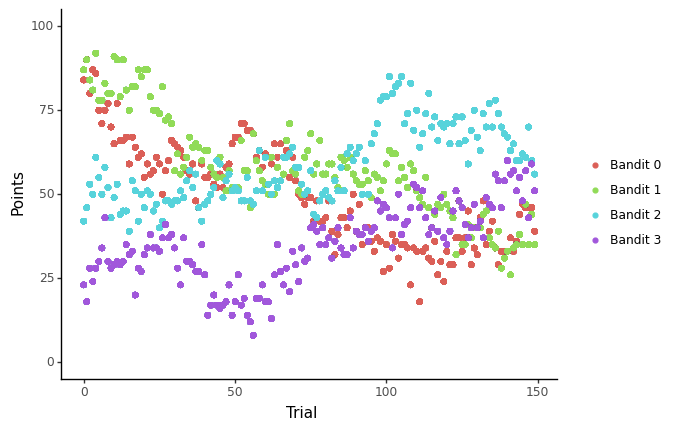

<ggplot: (8789983462509)>

In [14]:
# Now, let's create the plot we described above; trials go on the x-axis, rewards (in the "value" column) go on the y-axis, and colors distinguish bandits ("variable")
gg_points_over_trials = (gg.ggplot(long_data, gg.aes(x='trial_id', y='value', color='variable'))
 + gg.geom_point()
 + gg.labs(x='Trial', y='Points', color='')
 + gg.coord_cartesian(ylim=(0, 100))
)
gg_points_over_trials

## Exercise 3: Visualize human behavior (*10 minutes*)

Now, let's vizualize human behavior! Specifically, which bandits did participants choose on each trial of the task? Let's create a plot with the same structure as the one above. Specifically:
* Plot trials (from 0-150) on the x-axis
* Plot the proportion of participants who chose each bandit (from 0-100\%) on the y-axis
* Select a different color for each bandit to distinguish them

Hint: You will need the column `action` for this exercise.

Use the starter code below:

In [15]:
# Let's first add a separate "one-hot" column for each action that indicates if this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]  # this creates the following vector: 'action_0', 'action_1', 'action_2', 'action_3']
human_data[action_cols] = jax.nn.one_hot(jnp.array(human_data['action']), n_bandits)
human_data  # note how the dataset now contains 4 more columns, "action_0", "action_1", "action_2", and "action_3"

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD,action_0,action_1,action_2,action_3
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696,1.0,0.0,0.0,0.0
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983,0.0,1.0,0.0,0.0
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366,0.0,0.0,1.0,0.0
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475,0.0,0.0,0.0,1.0
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651,0.0,0.0,1.0,0.0
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087,0.0,0.0,1.0,0.0
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932,0.0,0.0,1.0,0.0
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784,0.0,0.0,1.0,0.0


In [16]:
# Now, let's melt the dataset in the same way as above, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_data = pd.melt(human_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_data

,participant_id,trial_id,variable,value
0,0,0,action_0,1.0
1,0,1,action_0,0.0
2,0,2,action_0,0.0
3,0,3,action_0,0.0
4,0,4,action_0,0.0
...,...,...,...,...
59995,99,145,action_3,0.0
59996,99,146,action_3,0.0
59997,99,147,action_3,0.0
59998,99,148,action_3,0.0


In [17]:
#@title Now, fill in the blanks for your solution:
gg_actions_over_trials = (gg.ggplot(long_data, gg.aes(x='...', y='...', color='...', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='...', y='...', color='')
 + gg.coord_cartesian(ylim=(0, 1))
)

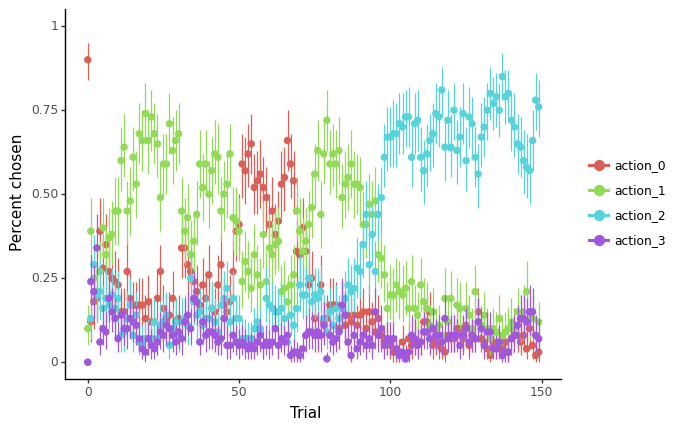

<ggplot: (8789874813493)>

In [18]:
#@title Click to show Solution 3
gg_actions_over_trials = (gg.ggplot(long_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
)
gg_actions_over_trials

Let's remind ourselves of the first plot we made again:

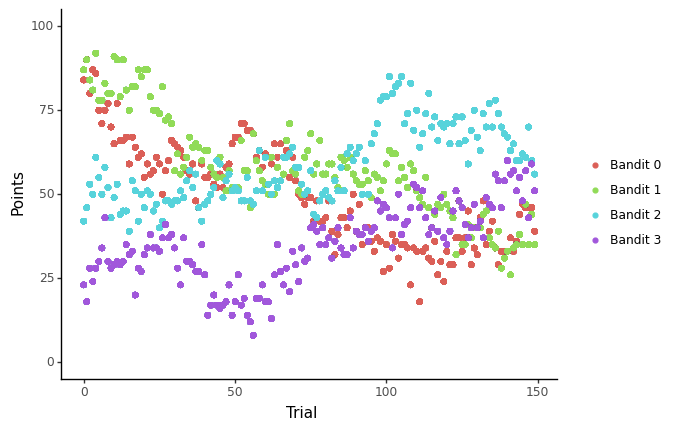

<ggplot: (8789983462509)>

In [19]:
gg_points_over_trials

## Exercise 4: Interpret findings (*5 minutes*)

In your group, compare the two plots you made, showing the available points (Part 3) and showing human choices (Exercise 3).
* What do you notice? (2 minutes)
* How do you explain the patterns you are seeing? (2 minutes)

## Share with the group

In one sentence, what have you learned about how humans do this task?

## Solution 5

Expand the cell below to see the solution.

* The two plots look quite similar: When one color line is high in one plot, it also tends to be high in the other.
* The explanation is that participants learn to choose the bandits that give the most points: Whenever a line is high in the first plot, there are lots of points to be earned, and this drives up the line in the second plot, which shows that participants tend to choose the corresponding action.

# Part 2: Train an RL agent to solve the same task

Now that we know how humans are doing the task, let's see if we can train an AI agent to do it!

We heard about four different approaches for training RL agents, namely:
* Rescorla Wagner
* TD learning
* Q-learning
* SARSA

## Exercise 1: Which method? (*5 minutes*)

In your group, think about which of these four methods would be best for our case.

(Hint: Look back at the task description and figures we made, and try to imagine what a value function and a policy would look like in this case. To chose one approach for training, consider if we need just a value function or also a policy; and whether we want to learn on-policy or off-policy.)

## Solution 1
Click below to expand.

We are interested in training an agent to *do* something, aka to *act*; therefore, we want to use an algorithm that learns an *action policy*, on top of a value function. This rules out Rescorla Wagner and TD learning, which only learn a value function (e.g., to predict Pavlovian responses), but no action policy.

We next have the choice between off-policy (Q-learning) and on-policy learning (SARSA): Whereas Q-learning calculates values based on the best action that *could have been chosen*, SARSA calculates values based on the action that *was actually chosen*. Because our environemnt is not stationary (aka, the rewards for the bandits are changing over time), the on-policy method works better here. Furthermore, SARSA usually uses a *stochastic* policy (aka, it doesn't select actions deterministically, but always has some randomness). This randomness will also help us here because we need "exploration" (aka, picking random actions once in a while) to discover when rewards are changing in the task.

## Section 2: Value update recap

Remember that in RL, we always calculate reward prediction errors $\delta$:

$$\delta_t = r_t - V_t(a_t)$$

In other words, we see how much reward $r$ we obtained on trial $t$ to get $r_t$. Then we check what the value $V$ is of the action $a$ we chose on trial $t$ to get $V_t(a_t)$. This entity $V_t(a_t)$ is our "reward prediction".

Now, all that's left is to look at the difference between $V_t(a_t)$ (our reward prediction) and the actual reward $r_t$, to obtain our "reward prediction error" $\delta_t$.

Now that we have our reward prediction error $\delta$, we are ready to update our value $V_t(a_t)$ to obtain $V_{t+1}(a_t)$:

$$V_{t+1}(a_t) = V_t(a_t) + \alpha * \delta_t$$

For the update, we *could* simply add the reward prediction error $\delta_t$ to our old value estimate $V_t$, to immediately arrive at $r_t$, the true outcome. However, we don't really want to move *all the way* from the old value $V_t$ to the actual outcome $r_t$. We only want to move *a little bit*, in order to keep around some of the things we have already learned in the past.

This is the reason why we first multiply $\delta_t$ by $\alpha$, the *learning rate*, before we add it to $V_t(a_t)$. (The learning rate $\alpha$ is a number between 0 and 1 that "scales" the reward prediction error. For example, if $\alpha=0.25$, we move a third of the way from $V_t$ to $r_t$.)

This is all you need to know about the RL value update!

## Exercise 2: Write the value function (*10 minutes*)

In your group, now implement this value update. Use the starter code below and fill in the blanks.

Remember:
* First, familiarize yourself with the starter code by reading through the entire cell (*2 minutes*)
* Then, fill in the blanks to calculate the RPE $\delta$ (first equation above; *4 minutes*)
* Now, fill in the blanks to calculate the new value $V_{t+1}$ (second equation above; *4 minutes*)

In [20]:
class RlAgent():
  """Define classic alpha-beta RL model."""
  def __init__(self, n_actions, rl_parameters, init_value=0.5):
    """Initialize RL model."""
    self._n_actions = n_actions
    self._init_value = init_value
    self._alpha = rl_parameters['alpha']
    self._beta = rl_parameters['beta']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    chosen_action_value = jnp.sum(action * value, axis=-1)
    # ============== FILL IN THE BLANKS IN THE LINE BELOW ================
    rpe = ...  # shape: (batch_size,)
    rpe = rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)
    # ============== FILL IN THE BLANKS IN THE LINE BELOW ================
    new_value = ...  # shape: (batch_size, n_actions)
    return new_value

  def calculate_action_probs(self, value):
    """Turn action values into action probabilities."""
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    """Turn action probabilities into actions."""
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  def initial_values(self, batch_size):
    """Initialize action values."""
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [21]:
#@title Click to expand solution
class RlAgent():
  """Define classic alpha-beta RL model."""
  def __init__(self, n_actions, rl_parameters, init_value=0.5):
    """Initialize RL model."""
    self._n_actions = n_actions
    self._init_value = init_value
    self._alpha = rl_parameters['alpha']
    self._beta = rl_parameters['beta']

  def update_values(self, value, action, reward):
    chosen_action_value = jnp.sum(action * value, axis=-1)
    rpe = reward - chosen_action_value  # shape: (batch_size,)
    rpe = rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)
    new_value = value + action * self._alpha * rpe  # shape: (batch_size, n_actions)
    return new_value

  def calculate_action_probs(self, value):
    """Turn action values into action probabilities."""
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    """Turn action probabilities into actions."""
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  def initial_values(self, batch_size):
    """Initialize action values."""
    return self._init_value * jnp.ones([batch_size, self._n_actions])

Now, let's see what this agent does!
Let's assume an agent with a learning rate of $\alpha = 0.3$ and a decision noise of $\beta=3$.

In [22]:
rl_parameters = {'alpha': 0.3, 'beta': 3.}
agent = RlAgent(n_actions=2, rl_parameters=rl_parameters)

Then, let's assume the agent chose action "0".

In [23]:
action_1h = np.array([[1, 0]])  # one-hot representation of action "0"

And let's assume the agent got a reward:

In [24]:
reward = 1  # reward for action "0" is 1

Let's now simulate a single agent (`batch_size=1`) for 4 trials (`n_trials_sim=4`). The agent will always choose action 0 and receive a reward, and we will see how its internal values for action 0 change over time.

In [25]:
batch_size = 1  # we simulate 1 agent
n_trials_sim = 4  # we simulate 4 trials

agent_values = agent.initial_values(batch_size)  # we initialize the agents' values
print(f'Initial action values {agent_values}')  # and print them

for trial in range(n_trials_sim):  # we run the agent for 4 trials
  print(f'\nTrial {trial}')
  print(f'Action {action_1h}')
  print(f'Reward {reward}')
  agent_values = agent.update_values(agent_values, action_1h, reward)
  print(f'New action values {agent_values}')
  action_probs = agent.calculate_action_probs(agent_values)
  print(f'Action probabilities {action_probs}')

Initial action values [[0.5 0.5]]

Trial 0
Action [[1 0]]
Reward 1
New action values [[0.65 0.5 ]]
Action probabilities [[0.6106392 0.3893608]]

Trial 1
Action [[1 0]]
Reward 1
New action values [[0.755 0.5  ]]
Action probabilities [[0.6824383  0.31756175]]

Trial 2
Action [[1 0]]
Reward 1
New action values [[0.82850003 0.5       ]]
Action probabilities [[0.7281982 0.2718018]]

Trial 3
Action [[1 0]]
Reward 1
New action values [[0.87995005 0.5       ]]
Action probabilities [[0.75765216 0.24234788]]


## Exercise 3: Understand the agent (*5 minutes*)

With your team, answer the following questions:
* What are the initial values for action 0 and for action 1? (*1 minute*)
* How does the value of action 0 change over time? (*1 minute*)
* How does the value of action 1 change over time? (*1 minute*)
* Explain why the values change in the way they do (*2 minutes*)

## Solution 3

Click below to expand.

* What are the initial values for action 0 and for action 1? -> 0.5 for both.
* How does the value of action 0 change over time? -> it increases, with smaller and smaller increments as the value approaches the asymptote of 1
* How does the value of action 1 change over time? -> it does not change
* Explain why the values change in the way they do -> the value of action 0 increases because the action is rewarded on each trial; the updates become smaller and smaller because the reward prediction errors become smaller and smaller as the value approache the true reward. The value of action 1 does not change because it is not chosen, and hence it is not updated.

## Section 3: Let the agent do the human task

Now, let's take it up a notch by letting the agent do the same task that humans do!

To do this, let's first look up the reward schedule, i.e., how many points each bandit gives on each trial:

In [26]:
reward_schedule = human_data[['reward_action{}'.format(i) for i in range(n_bandits)]].values / 100
reward_schedule

array([[0.84, 0.87, 0.42, 0.23],
       [0.9 , 0.9 , 0.46, 0.18],
       [0.8 , 0.84, 0.53, 0.28],
       ...,
       [0.46, 0.35, 0.7 , 0.43],
       [0.46, 0.44, 0.6 , 0.59],
       [0.39, 0.35, 0.56, 0.51]])

Now, let's let the agent work on this task, and see what actions it chooses, and how it updates the action values:

In [27]:
agent = RlAgent(n_actions=n_bandits, rl_parameters=rl_parameters)
agent_values = agent.initial_values(batch_size)
print(f'Action values {agent_values}')

for trial in range(n_trials_sim):

  print(f'\nTrial {trial}')

  action_probs = agent.calculate_action_probs(agent_values)
  print(f'Action probabilities {action_probs}')

  action = agent.choose_action(action_probs)
  action_1h = jax.nn.one_hot(action, n_bandits)
  print(f'Chosen action {action_1h}')

  reward = reward_schedule[trial, action]
  print(f'Obtained reward {reward}')

  agent_values = agent.update_values(agent_values, action_1h, reward)
  print(f'Action values {agent_values}')

Action values [[0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]]
Chosen action [[0. 0. 1. 0.]]
Obtained reward [0.42]
Action values [[0.5        0.5        0.47599998 0.5       ]]

Trial 1
Action probabilities [[0.25441855 0.25441855 0.23674433 0.25441855]]
Chosen action [[0. 1. 0. 0.]]
Obtained reward [0.9]
Action values [[0.5        0.62       0.47599998 0.5       ]]

Trial 2
Action probabilities [[0.22915491 0.3284545  0.21323574 0.22915491]]
Chosen action [[1. 0. 0. 0.]]
Obtained reward [0.8]
Action values [[0.59000003 0.62       0.47599998 0.5       ]]

Trial 3
Action probabilities [[0.28027678 0.30667162 0.19909409 0.21395752]]
Chosen action [[0. 0. 1. 0.]]
Obtained reward [0.5]
Action values [[0.59000003 0.62       0.48319998 0.5       ]]


## Exercise 4: Modify the task (*10 minutes*)

With your group:
* Run the agent 5 times (execute the cell above 5 times) and note the final values. (*2 minutes*)
* What do you notice? How do you explain this result? (*3 minutes*)
* Now, run the agent for 100 trials (instead of 4). You can run the agent a few times. What do you notice? (*2 minutes*)

## Solution 4

Expand the cell below.

* Run the agent 5 times (execute the cell above 5 times) and note the final values -> it depends on your specific results
* What do you notice? How do you explain this result? -> we notice that the final values are different each time! How can this be? The explanation is that the agent chooses actions with some randomness, so it will choose different actions each time it encounters the task, even though the task is the same. And because it chooses different actions, it receives different rewards, and will update different values. Hence, the final values will be different.
* Now, run the agent for 100 trials (instead of 4). You can run the agent a few times. What do you notice? -> The values are different from the values we saw before. This is because the reward payoffs change over time, like we saw before. On trial 100, the values will be similar to what we saw in our first plot, around trial 100.

## Exercise 5: Train a "batch" of RL agents (*10 minutes*)

We will now train a whole "batch" of agents (`batch_size=150`) on the human task, and save the resulting data to compare it to humans later!

To do this, we need to use the loop over trials from above, and we need to add some lists that collect the agent responses and rewards.

In your group:
* Read through the cell below and identify the loop over trials (*2 minutes*)
* Figure out where agents choose actions; and where the chosen actions will be saved (*2 minutes*)
* Now, fill in the blanks: Make sure that rewards and agent values will be saved as well (*3 minutes*)

In [28]:
def simulate_rl_agents(agent, batch_size, n_trials, n_bandits, init_value=0.5, verbose=False):
  """Simulate batch_size RL agents on n_trials of the human task."""

  all_actions = []
  # ============== FILL IN THE BLANKS IN THE LINES BELOW ================
  all_rewards = ...
  all_values = ...

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = agent.choose_action(action_probs)
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = reward_schedule[trial, action]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    # ============== FILL IN THE BLANKS IN THE LINES BELOW ================
    all_rewards += ...
    all_values += ...

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    }

In [29]:
#@title Click to show solution
def simulate_rl_agents(agent, batch_size, n_trials, n_bandits, init_value=0.5, verbose=False):
  """Simulate batch_size RL agents on n_trials of the human task."""

  all_actions = []
  # ============== FILL IN THE BLANKS IN THE LINE BELOW ================
  all_rewards = []
  all_values = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = agent.choose_action(action_probs)
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = reward_schedule[trial, action]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    }

## Exercise 6: Run the simulation (*10 minutes*)

Now, let's run the code to create some agent simulations:
* Create a simulation for 2 agents and 3 trials (*2 minutes*)
* Look at the print-out while the simulation is running. What do you notice? (*2 minutes*)

In [30]:
n_rl_agents = 2  # how many agents should we simulate?
n_rl_agent_trials = 3  # how many trials should the simulation run for (for each agent)?

agent = RlAgent(n_actions=n_bandits, rl_parameters=rl_parameters)  # initiate the agent

simulation = simulate_rl_agents(agent, n_rl_agents, n_rl_agent_trials, n_bandits, verbose=True)  # run the simulation, printing each trial

Initial action values [[0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5]]

Trial 0
Action probabilities [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
Chosen action [[0. 0. 1. 0.]
 [1. 0. 0. 0.]]
Obtained reward [0.42 0.84]
New action values [[0.5        0.5        0.47599998 0.5       ]
 [0.602      0.5        0.5        0.5       ]]

Trial 1
Action probabilities [[0.25441855 0.25441855 0.23674433 0.25441855]
 [0.31160805 0.229464   0.229464   0.229464  ]]
Chosen action [[0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Obtained reward [0.46 0.18]
New action values [[0.5        0.5        0.4712     0.5       ]
 [0.602      0.5        0.5        0.40399998]]

Trial 2
Action probabilities [[0.2552826  0.2552826  0.23415217 0.2552826 ]
 [0.3305908  0.24344265 0.24344265 0.18252394]]
Chosen action [[0. 0. 0. 1.]
 [1. 0. 0. 0.]]
Obtained reward [0.28 0.8 ]
New action values [[0.5        0.5        0.4712     0.43400002]
 [0.6614     0.5        0.5        0.40399998]]


Now, look at the result of the simulation:
* Which actions did the first agent pick? (*1 minute*)
* Which actions did the second agent pick? (*1 minute*)
* Which rewards did the first agent obtain? Which rewards did the second agent obtain? (*1 minute*)

In [31]:
simulation['all_actions'], simulation['all_rewards']  # look at the simulation results

(array([[2, 0],
        [2, 3],
        [3, 0]], dtype=int32),
 array([[0.42, 0.84],
        [0.46, 0.18],
        [0.28, 0.8 ]]))

## Section 7: Create a dataset of artificial agents

Now, let's create a dataset of agents, similar to the human dataset. To do this, we will run our simulation function for 100 RL agents (because we have 100 human participants) and for 150 trials (because humans did 150 trials).

Then, we will compare the artificial agents to humans.

In [32]:
# Let's run 100 agents on 150 trials of the task
# NOTE: this cell will take a while to execute - be patient :)
n_rl_agents = 100
n_rl_agent_trials = 150

simulation = simulate_rl_agents(agent, n_rl_agents, n_rl_agent_trials, n_bandits)

In [33]:
# Let's now reshape the simulation data into the same form as the human dataset
actions_long = np.array(simulation['all_actions']).T.flatten()
rewards_long = np.array(simulation['all_rewards']).T.flatten()
rl_agent_data = pd.DataFrame({'action': actions_long, 'reward': rewards_long})
rl_agent_data['trial_id'] = np.tile(np.arange(n_rl_agent_trials), n_rl_agents)
rl_agent_data['participant_id'] = np.repeat(np.arange(n_rl_agents), n_rl_agent_trials)
rl_agent_data

,action,reward,trial_id,participant_id
0,3,0.23,0,0
1,3,0.18,1,0
2,2,0.53,2,0
3,3,0.24,3,0
4,0,0.86,4,0
...,...,...,...,...
14995,3,0.48,145,99
14996,2,0.61,146,99
14997,2,0.70,147,99
14998,0,0.46,148,99


In [34]:
# Let's add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
rl_agent_data[action_cols] = jax.nn.one_hot(jnp.array(rl_agent_data['action']), n_bandits)
rl_agent_data

,action,reward,trial_id,participant_id,action_0,action_1,action_2,action_3
0,3,0.23,0,0,0.0,0.0,0.0,1.0
1,3,0.18,1,0,0.0,0.0,0.0,1.0
2,2,0.53,2,0,0.0,0.0,1.0,0.0
3,3,0.24,3,0,0.0,0.0,0.0,1.0
4,0,0.86,4,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
14995,3,0.48,145,99,0.0,0.0,0.0,1.0
14996,2,0.61,146,99,0.0,0.0,1.0,0.0
14997,2,0.70,147,99,0.0,0.0,1.0,0.0
14998,0,0.46,148,99,1.0,0.0,0.0,0.0


In [35]:
# Let's melt the dataset again, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_rl_agent_data = pd.melt(rl_agent_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_rl_agent_data

,participant_id,trial_id,variable,value
0,0,0,action_0,0.0
1,0,1,action_0,0.0
2,0,2,action_0,0.0
3,0,3,action_0,0.0
4,0,4,action_0,1.0
...,...,...,...,...
59995,99,145,action_3,1.0
59996,99,146,action_3,0.0
59997,99,147,action_3,0.0
59998,99,148,action_3,0.0


## Exercise 8: Visualize agent behavior

Let's visualize agent behavior in the same way as we visualized human choices before. Fill in the blanks below:

In [36]:
# ================= UNCOMMENT THE LINES BELOW AND FILL IN THE BLANKS ===============
# gg_actions_over_trials_rl_agents = (gg.ggplot(..., gg.aes(x='...', y='...', color='...', group='variable'))
#  + gg.stat_summary()
#  + gg.labs(x='...', y='...', color='')
#  + gg.coord_cartesian(ylim=(0, 1))
#  + gg.labs(title='Trained RL agents (choices)')
# )

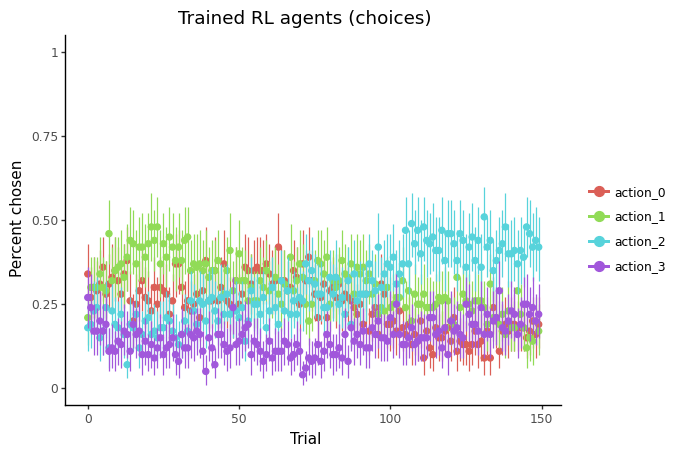

<ggplot: (8789874421451)>

In [37]:
#@title Click to show Solution 8
gg_actions_over_trials_rl_agents = (gg.ggplot(long_rl_agent_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
 + gg.labs(title='Trained RL agents')
)
gg_actions_over_trials_rl_agents

Let's remind ourselves what human behavior looked like:

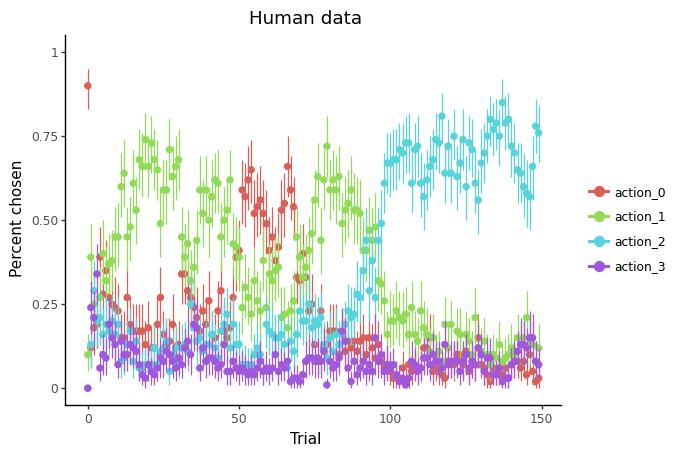

<ggplot: (8789874192213)>

In [38]:
gg_actions_over_trials + gg.labs(title='Human data')

## Exercise 9: Interpret simulation (*10 minutes*)

* What do you see? How do the agents compare to humans? What are the most striking similarities and differences? (*3 minutes*)
* What do you think about using the RL agents as a model of humans? Do you have ideas for how to improve the situation? (*3 minutes*)
* Thinking back about the lecture, what could our next steps be? (*3 minutes*)

# Part 3: Use RL as a model for human behavior

We have just trained an RL agent to do the task. We next want to test if humans might be using RL to learn the task. How can we do this?

To see if humans use RL to solve the task, we "fit" the RL model to human behavior. This means that we "squeeze" and "stretch" the RL agent (like a cookie cutter) until it produces behavior that corresponds to the human behavior (dough pancake).

In this case, the "squeezing" and "stretching" consists of increasing or decreasing the values of the *free parameters* of the model, learning rate $\alpha$ and decision temperature $\beta$.

How do we know if we need to change the values of $\alpha$ and $\beta$? By checking how close the behavior of the model is to human behavior (i.e., how similar the model pancake is to the human pancake). The closer the model behavior matches human behavior, the better the model "fits" the human dataset, and the less we have to change the parameters.

On the other hand, the more different the model behavior is from human behavior, the more we have to still wiggle on $\alpha$ and $\beta$ to get it closer. We want the best possible fit, so we are looking for the values of $\alpha$ and $\beta$ that maximize the similarity between human and model behavior. To do this, we will *maximizes the probability* that the RL agent chooses the same actions that humans have chosen.

**Saying the same thing in more technical terms, our goal is to find the values of our model parameters ($\alpha$ and $\beta$) that maximize the likelihood of the observed (human) behavior under the model.**

To do this, we need to know *how likey* the observed behavior is under each parameter setting. Once we know all the likelihoods, all we have to do is find the largest one - it will come the best parameters.

In summary, we will do the following:

* **STEP 1**: Calculate the likelihood of the human dataset for different parameters.

* **STEP 2**: Find the parameters with the largest likelihood; these will be the optimal parameters.

## Section 1: Calculate the likelihood

In order to calculate the likelihood of the human data, we first need to modify our agent code:
* Instead of choosing its own actions, the agent now needs to analyze human actions
* Specifically, instead of calculating action probabilities and then choosing actions based on these probabilities, the agent needs to look at the human actions and then calculate their action probabilities

So, let's first modify our simulation function to accept an external dataset of actions and rewards that "force" the RL agent's choices on each trial.

## Exercise 1: Force agent to use human actions (*5 minutes*)

Fill in the blanks below to make sure the agents choose the human actions, and receive the human rewards.

In [39]:
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    # ============== FILL IN THE BLANKS BELOW ================
    action = fitted_data.loc[fitted_data['trial_id'] == trial, ...].values[:batch_size]  # look up humans' action at trial 'trial'
    action_1h = jax.nn.one_hot(action, n_bandits)
    # ============== FILL IN THE BLANKS BELOW ================
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, ...].values[:batch_size]  # look up humans' reward_01 at trial 'trial'
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    }

In [40]:
#@title Solution 1: Click to expand
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    # ============== FILL IN THE BLANKS BELOW ================
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]  # look up humans' action at trial 'trial'
    action_1h = jax.nn.one_hot(action, n_bandits)
    # ============== FILL IN THE BLANKS BELOW ================
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]  # look up humans' reward_01 at trial 'trial'
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    }

In [41]:
# Let's first create a new column in the dataset that divides the rewards by 100
human_data['reward_01'] = human_data['reward'] / 100
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD,action_0,action_1,action_2,action_3,reward_01
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696,1.0,0.0,0.0,0.0,0.84
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983,0.0,1.0,0.0,0.0,0.90
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366,0.0,0.0,1.0,0.0,0.53
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475,0.0,0.0,0.0,1.0,0.24
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036,0.0,1.0,0.0,0.0,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651,0.0,0.0,1.0,0.0,0.62
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087,0.0,0.0,1.0,0.0,0.61
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932,0.0,0.0,1.0,0.0,0.70
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784,0.0,0.0,1.0,0.0,0.60


Let's first check that the agent is now using the same actions as humans, and getting the same rewards as humans:

In [42]:
agent = RlAgent(n_actions=n_bandits, rl_parameters=rl_parameters)
n_trials_sim = 5

simulation = fit_rl_agent(agent, human_data, batch_size=1, n_trials=n_trials_sim, verbose=False)

print(f'Agent actions:{simulation["all_actions"].flatten()}')
print(f"Human actions:{human_data['action'][:n_trials_sim].values}")
print(f"\nAgent rewards:{simulation['all_rewards'].flatten()}")
print(f"Human rewards:{human_data['reward'][:n_trials_sim].values}")

Agent actions:[0. 1. 2. 3. 1.]
Human actions:[0. 1. 2. 3. 1.]

Agent rewards:[0.84 0.9  0.53 0.24 0.92]
Human rewards:[84. 90. 53. 24. 92.]


Now, let's use our function to calculate the probabilities of each (human) action choice. For this, we need to keep track of the agents' action probabilities.

## Exercise 2: Collect action probabilities (*5 minutes*)

Fill in the blanks below to store each trial's action probabilities in a list and return that list at the end.

In [43]:
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []
  # ============== FILL IN THE BLANKS BELOW ================
  all_action_probs = ...

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]
    # ============== FILL IN THE BLANKS BELOW ================
    all_action_probs += ...

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    # ============== FILL IN THE BLANKS BELOW ================
    'all_action_probs': ...,
    }

In [44]:
#@title Solution 2: Click to expand
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []
  # ============== FILL IN THE BLANKS BELOW ================
  all_action_probs = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]
    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]
    # ============== FILL IN THE BLANKS BELOW ================
    all_action_probs += [action_probs]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    # ============== FILL IN THE BLANKS BELOW ================
    'all_action_probs': np.array(all_action_probs),
    }

## Exercise 3: Interpret the action probabilities

Let's take a look at these action probabilities!

* What is the shape of `all_action_probs`? (*1 minute*)
* What does each dimension of `all_action_probs` refer to? (*1 minute*) [Hint: remember that there is one value for each participant, for each trial, for each bandit.]
* What is the probability for participant 0 to choose action 0 on trial 0? (Given)
* What is the probability for participant 1 to choose action 3 on trial 2? (*2 minutes*)

Use the cell below to find the answer.

In [45]:
simulation = fit_rl_agent(agent, human_data, batch_size=2, n_trials=n_trials_sim, verbose=False)
all_action_probs = simulation['all_action_probs']
all_action_probs

array([[[0.25      , 0.25      , 0.25      , 0.25      ],
        [0.25      , 0.25      , 0.25      , 0.25      ]],

       [[0.31160805, 0.229464  , 0.229464  , 0.229464  ],
        [0.31160805, 0.229464  , 0.229464  , 0.229464  ]],

       [[0.283426  , 0.29915178, 0.2087111 , 0.2087111 ],
        [0.283426  , 0.29915178, 0.2087111 , 0.2087111 ]],

       [[0.2818163 , 0.29745275, 0.21320526, 0.20752575],
        [0.2818163 , 0.29745275, 0.21320526, 0.20752575]],

       [[0.29457054, 0.31091467, 0.22285435, 0.17166047],
        [0.29457054, 0.31091467, 0.22285435, 0.17166047]]], dtype=float32)

In [46]:
print(f"Shape of `all_action_probs.shape`: {...}")
print(f"probability for participant 0 to choose action 0 on trial 0: {all_action_probs[0, 0, 0]}")
print(f"probability for participant 1 to choose action 3 on trial 2: {...}")

Shape of `all_action_probs.shape`: Ellipsis
probability for participant 0 to choose action 0 on trial 0: 0.25
probability for participant 1 to choose action 3 on trial 2: Ellipsis


In [47]:
#@title Solution 3: Click to expand
print(f"Shape of `all_action_probs.shape`: {all_action_probs.shape}")
print(f"probability for participant 0 to choose action 0 on trial 0: {all_action_probs[0, 0, 0]}")
print(f"probability for participant 1 to choose action 3 on trial 2: {all_action_probs[2, 1, 3]}")

Shape of `all_action_probs.shape`: (5, 2, 4)
probability for participant 0 to choose action 0 on trial 0: 0.25
probability for participant 1 to choose action 3 on trial 2: 0.20871110260486603


Now, we have a function that calculates the probability for each human participant to choose each of the four actions on each trial.

To calculate the likelihood of the whole dataset, we now just need to sum the probabilities of the actions that participants have actually chosen. And we need to take the log and the negative of these probabilities. (The reason for the log is this that we want to sum instead of multiplying. And the reason for taking the negative is that it is easier to *minimize* functions than to *maximize* them.)

The function below does all of this for us:

In [48]:
def calculate_neg_log_likelihood(agent, n_trials, batch_size):

  simulation = fit_rl_agent(agent, human_data, batch_size=batch_size, n_trials=n_trials)
  all_actions_1h = np.array(jax.nn.one_hot(simulation['all_actions'], num_classes=n_bandits))

  chosen_action_probs = np.sum(all_actions_1h * np.array(simulation['all_action_probs']), axis=-1)  # this is a list of action probabilities, with one probability per trial, showing the agent's probability of choosing the chosen action
  chosen_action_probs += 1e-5  # we add a very small number to avoids 0's, for which the log would be -inf, which would destroy our calculation
  av_neg_log_likelihood = -np.sum(np.log(chosen_action_probs)) / n_trials / batch_size  # now, we average the log-likelihoods over all participants and all trials, to get an average trial-based measure

  return av_neg_log_likelihood

# Test
calculate_neg_log_likelihood(agent=agent, n_trials=5, batch_size=2)  # Calculate the negative log likelihood for the agent we specified above, for 5 trials, and for 2 participants

1.433126449584961

## Exercise 4: Calculate negative log likelihoods (NLLs) for different parameters

Now, let's find the optimal parameters! For this, we have to calculate the NLLs for different parameters, and then find the smallest one. The smallest NLL will come from the best parameters.

Fill in the blanks below to do this:

In [49]:
nlls = []
n_points_sqrt = 5
batch_size = 100
n_trials = 150
min_beta = 1.
max_beta = 30.

for alpha in np.arange(n_points_sqrt) / n_points_sqrt:
  print(alpha)
  for beta in min_beta + np.arange(n_points_sqrt) / n_points_sqrt * max_beta:

    # ============== FILL IN THE BLANKS BELOW ================
    agent = RlAgent(n_actions=n_bandits, rl_parameters={'alpha': ..., 'beta': ...})  # create an agent that uses the parameters we specified in the loop
    # ============== FILL IN THE BLANKS BELOW ================
    nll = ...  # calculate the negative log likelihood, using the function above

    nlls.append([alpha, beta, nll])

nlls = pd.DataFrame(nlls, columns=['alpha', 'beta', 'nll'])

0.0
0.2
0.4
0.6
0.8


In [50]:
#@title Click to expand solution
nlls = []
n_points_sqrt = 5
batch_size = 100
n_trials = 150
min_beta = 1.
max_beta = 30.

for alpha in np.arange(n_points_sqrt) / n_points_sqrt:
  print(alpha)
  for beta in min_beta + np.arange(n_points_sqrt) / n_points_sqrt * max_beta:

    agent = RlAgent(n_actions=n_bandits, rl_parameters={'alpha': alpha, 'beta': beta})  # create an agent that uses the parameters we specified in the loop
    nll = calculate_neg_log_likelihood(agent, n_trials, batch_size)  # calculate the negative log likelihood, using the function above

    nlls.append([alpha, beta, nll])

nlls = pd.DataFrame(nlls, columns=['alpha', 'beta', 'nll'])

0.0
0.2
0.4
0.6
0.8


**SIDE NOTE**: In reality, we would use a *function optimizer* to find the best parameters, instead of doing *grid search* like we did above. We will get to this in the next section.

*Grid search* means that we manually calculate results for the entire "grid" of possible solutions. In this case, we manually calculated the NLLs for each possible pair of $\alpha$ and $\beta$. We then look at the grid and find the spot with the best result, aka the smallest NLL.

*Function optimization* means that we automatize this process: We submit our NLL function to an optimizer that automatically finds the minimum of the function. This saves time because function optimizers are usually very fast and have smarter strategies for finding a minimum than checking everywhere. (In particular, they use the gradient: they check how the result changes if we make the parameter a bit bigger and how it changes when we make it a bit smaller, and decide which way to search next based on which direction looks more promising.)

Let's look at the result of our *grid search*:

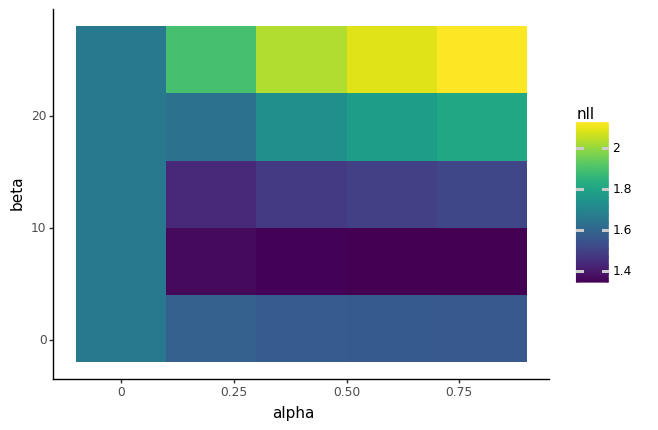

<ggplot: (8789874621098)>

In [51]:
nll_plot = (gg.ggplot(nlls, gg.aes(x='alpha', y='beta', fill='nll'))
 + gg.geom_tile()
)
nll_plot

## Exercise 5: Interpret grid search (*5 minutes*)

Interpret the plot above:
* What do the x-axis, y-axis, and colors show? (*2 minutes*)
* Can you read out the best parameters from this figure? (*2 minutes*)

## Solution 5

Let's mark the best parameters with a red cross to make it easier to find!

In [52]:
# Find the best parameters
best_nll = np.min(nlls['nll'])  # find the smallest (aka, best) NLL
best_model = nlls.loc[nlls['nll'] == best_nll,]  # look up alpha and beta where the NLL is best
best_model['marker'] = 'X'  # specify how we'll show this value on the plot
best_model  # look at the NLL, alpha, and beta of the best model

<ipython-input-52-7c16742c872f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,alpha,beta,nll,marker
16,0.6,7.0,1.364674,X


Now, let's plot everything!

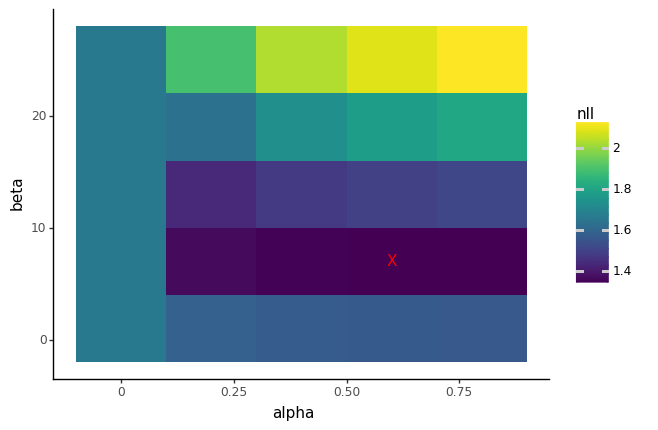

<ggplot: (8789873839315)>

In [53]:
# Make the same plot as before, marking the best parameters using a red cross
nll_plot = (gg.ggplot(nlls, gg.aes(x='alpha', y='beta', fill='nll'))
 + gg.geom_tile()
 + gg.geom_text(best_model, gg.aes(label='marker'), color='red')
)
nll_plot

Here is a high-resolution version of the same plot:

<center><img src="https://github.com/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/23-Friday/NllGrid.png?raw=1" width=1000></center>

## Section 6: Simulate agents, plot, interpret

In order to see if our agents are a good model for humans, let's compare both side-by-side! To do this, we can simulate behavior from our artificial agents and simply compare it to human behavior.

In [54]:
# Let's look up the fitted parameters
best_rl_parameters = {'alpha': best_model['alpha'].values[0], 'beta': best_model['beta'].values[0]}  # this line will use the parameters you have calculated
best_rl_parmaeters = {'alpha': 0.76, 'beta': 6.3999999999999995}  # here are the parameters using the same code, but a finer grain in our grid search (`n_points_sqrt = 50`)
best_rl_parameters

{'alpha': 0.6, 'beta': 7.0}

In [55]:
# Simulate the agent using the fitted parameters
agent = RlAgent(n_actions=n_bandits, rl_parameters=best_rl_parameters)
simulation = simulate_rl_agents(agent, n_participants, n_trials, n_bandits)

In [56]:
# (Boring) formatting of the simulation data
actions_long = np.array(simulation['all_actions']).T.flatten()
rewards_long = np.array(simulation['all_rewards']).T.flatten()
rl_model_data = pd.DataFrame({'action': actions_long, 'reward': rewards_long})
rl_model_data['trial_id'] = np.tile(np.arange(n_trials), n_participants)
rl_model_data['participant_id'] = np.repeat(np.arange(n_participants), n_trials)

# Add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
rl_model_data[action_cols] = jax.nn.one_hot(jnp.array(rl_model_data['action']), n_bandits)

# Melt the dataset again, so that every row contains just one action ("variable"), indicating whether it was chosen or not ("value")
long_rl_model_data = pd.melt(rl_model_data[['participant_id', 'trial_id'] + action_cols], id_vars=['participant_id', 'trial_id'])
long_rl_model_data

,participant_id,trial_id,variable,value
0,0,0,action_0,0.0
1,0,1,action_0,1.0
2,0,2,action_0,1.0
3,0,3,action_0,1.0
4,0,4,action_0,1.0
...,...,...,...,...
59995,99,145,action_3,1.0
59996,99,146,action_3,0.0
59997,99,147,action_3,0.0
59998,99,148,action_3,0.0


Now, let's look at simulated agent behavior, and compare it to human behavior, as well as to the behavior of our un-fitted RL agents:

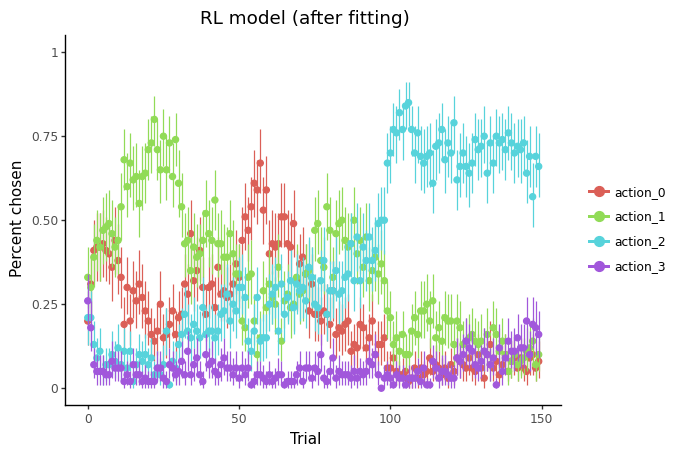

<ggplot: (8789874265890)>

In [57]:
gg_actions_over_trials_rl_model = (gg.ggplot(long_rl_model_data, gg.aes(x='trial_id', y='value', color='variable', group='variable'))
 + gg.stat_summary()
 + gg.labs(x='Trial', y='Percent chosen', color='')
 + gg.coord_cartesian(ylim=(0, 1))
 + gg.labs(title='RL model (after fitting)')
)
gg_actions_over_trials_rl_model

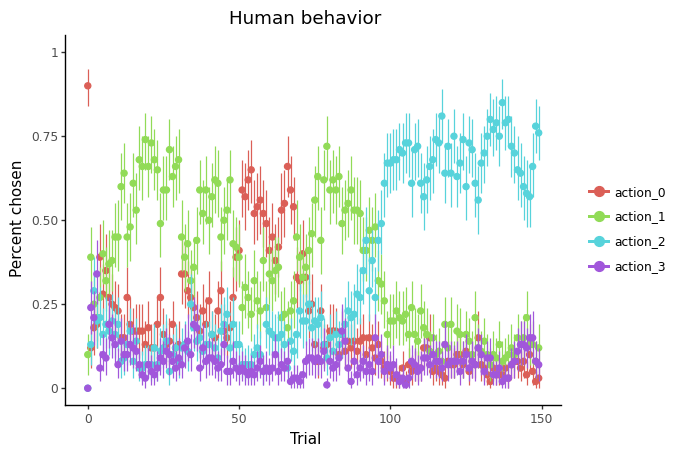

<ggplot: (8789874268151)>

In [58]:
gg_actions_over_trials + gg.labs(title='Human behavior')

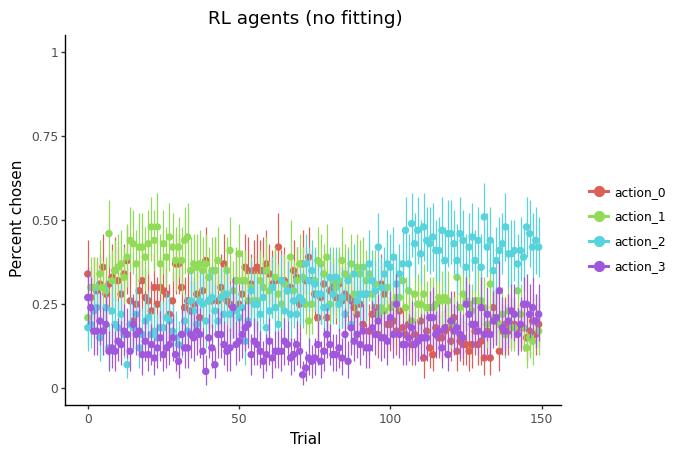

<ggplot: (8789865281660)>

In [59]:
gg_actions_over_trials_rl_agents + gg.labs(title='RL agents (no fitting)')

## Exercise 7: Interpret findings (*10 minutes*)
What do you conclude from our findings?
* How has the model fitting changed model behavior? (*5 minutes*)
* What does this tell us about human behavior on this task? What can we conclude? (*5 minutes*)

## Solution 7

* after fitting: better congruence between human and RL model behavior
* human behavior: can be explained as an RL process -> humans might be using RL-like processes to perform this task; the brain might implement an RL-like algorithm, so there might be brain areas that perform the relevant computations (more about that later); people with difficulties learning or making decisions might suffer from brain abnormalities that we could categorize using these models.
* we can explain differences in behavior as differences in model parameters (e.g., learning rate $\alpha$, decision temperature $\beta$), or as differences of the underlying model (e.g., RL versus something else); model fitting and model comparison (see below) can answer this question
* the model also allows us to make predictions: we can feed it with new parameters, click start, and see what behavior should look like; for example, if we identify a condition that affects the learning rate, we can make prediction what behavior should look like in different scenarios, using the model

## Exercise 8: Thinking deeper (*10 minutes*)

What are the advantages and disadvantages of the model fitting method, in your opinion? What are its limitations? What could we do to go beyond these limitations?

# Part 4: Use RL as a neural model

Like we've seen in the lecture, there is lots of evidence that the brain might implent an RL algorithm: The dopamine system has been argued to calculate reward prediction errors (RPEs), such that dopamine neurons *increase* their firing rates when there is a *positive* RPE (reward is *larger* than expected), and *decrease* their firing rates when there is a *negative* RPE (reward is *smaller* than expected).

In this section, we will see if this is the case in our dataset.

**STEP 1**: Calculate RPEs. For each trial in the task, calculate the RPE the model is encountering.

**STEP 2**: Plot the model-based RPEs against the human fMRI signal.

**STEP 3**: Calculate the correlation between model-based RPEs and striatal BOLD signal.

## Exercise 1

Let's modify our fitting function to calculate RPEs, to keep track of them, and to return them at the end. (Hint: Look up the equation for RPEs $\delta$ above!) Fill in the blanks below:

In [60]:
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []
  all_action_probs = []
  # ============== FILL IN THE BLANKS BELOW ================
  all_rpes = ...

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]

    # ============== FILL IN THE BLANKS BELOW ================
    chosen_action_value = np.sum(action_1h * agent_values, axis=-1)
    rpe = ...

    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]
    all_action_probs += [action_probs]
    # ============== FILL IN THE BLANKS BELOW ================
    all_rpes += ...

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')
      print(f'RPE {rpe}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    'all_action_probs': np.array(all_action_probs),
    # ============== FILL IN THE BLANKS BELOW ================
    'all_rpes': ...
    }

In [61]:
#@title Click to expand solution
def fit_rl_agent(agent, fitted_data, batch_size=n_participants, n_trials=n_trials, init_value=0.5, verbose=False):

  all_actions = []
  all_rewards = []
  all_values = []
  all_action_probs = []
  # ============== FILL IN THE BLANKS BELOW ================
  all_rpes = []

  agent_values = agent.initial_values(batch_size)

  if verbose:
    print(f'Initial action values {agent_values}')

  for trial in range(n_trials):

    action_probs = agent.calculate_action_probs(agent_values)
    action = fitted_data.loc[fitted_data['trial_id'] == trial, 'action'].values[:batch_size]
    action_1h = jax.nn.one_hot(action, n_bandits)
    reward = fitted_data.loc[fitted_data['trial_id'] == trial, 'reward_01'].values[:batch_size]

    # ============== FILL IN THE BLANKS BELOW ================
    chosen_action_value = np.sum(action_1h * agent_values, axis=-1)
    rpe = reward - chosen_action_value

    agent_values = agent.update_values(agent_values, action_1h, reward)

    all_actions += [action]
    all_rewards += [reward]
    all_values += [agent_values]
    all_action_probs += [action_probs]
    # ============== FILL IN THE BLANKS BELOW ================
    all_rpes += [rpe]

    if verbose:
      print(f'\nTrial {trial}')
      print(f'Action probabilities {action_probs}')
      print(f'Chosen action {action_1h}')
      print(f'Obtained reward {reward}')
      print(f'New action values {agent_values}')
      print(f'RPE {rpe}')

  return {
    'all_actions': np.array(all_actions),
    'all_rewards': np.array(all_rewards),
    'all_values': np.array(all_values),
    'all_action_probs': np.array(all_action_probs),
    # ============== FILL IN THE BLANKS BELOW ================
    'all_rpes': np.array(all_rpes)
    }

Let's now use the function to calculate the RPEs our model predicts each human is experiencing on each trial of the task.

In [62]:
# Calculate RPEs for all humans, all trials, based on the fitted parameters
agent = RlAgent(n_bandits, best_rl_parameters)
fit = fit_rl_agent(agent, human_data, batch_size=100, n_trials=150, init_value=0.5)

In [63]:
human_data['fitted_rpes'] = fit['all_rpes'].T.flatten()  # attach the result to our dataframe
human_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,BOLD,action_0,action_1,action_2,action_3,reward_01,fitted_rpes
0,0,0.0,84.0,1104.0,84,87,42,23,0,False,-0.431696,1.0,0.0,0.0,0.0,0.84,0.340000
1,0,1.0,90.0,1076.0,90,90,46,18,1,False,-1.838983,0.0,1.0,0.0,0.0,0.90,0.400000
2,0,2.0,53.0,612.0,80,84,53,28,2,False,-0.586366,0.0,0.0,1.0,0.0,0.53,0.030000
3,0,3.0,24.0,742.0,87,81,50,24,3,False,-1.954475,0.0,0.0,0.0,1.0,0.24,-0.260000
4,0,1.0,92.0,927.0,86,92,61,28,4,False,0.171036,0.0,1.0,0.0,0.0,0.92,0.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,99,2.0,62.0,679.0,47,35,62,48,145,False,-0.611651,0.0,0.0,1.0,0.0,0.62,0.011997
14996,99,2.0,61.0,686.0,46,47,61,57,146,False,-2.034087,0.0,0.0,1.0,0.0,0.61,-0.005201
14997,99,2.0,70.0,600.0,46,35,70,43,147,False,0.105932,0.0,0.0,1.0,0.0,0.70,0.087919
14998,99,2.0,60.0,641.0,46,44,60,59,148,False,2.235784,0.0,0.0,1.0,0.0,0.60,-0.064832


## Exercise 2: Plot RPEs against the human BOLD signal

Create a plot that shows the correspondence between model-based RPEs and human BOLD signal:

* Put the human BOLD signal on the x-axis and fitted RPEs on the y-axis
* Use the color of the dots to discriminate participants

In [67]:
# ============== UNCOMMENT THE CODE BELOW, THEN FILL IN THE BLANKS BELOW ================
# (gg.ggplot(human_data, gg.aes(x='...', y='...', color='...'))
#   + gg.geom_point(size=0.1)
#   + gg.geom_smooth()
# )

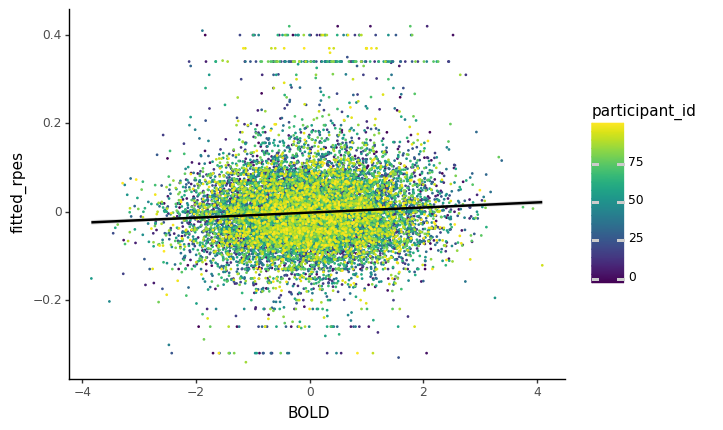

<ggplot: (8789865324118)>

In [68]:
#@title Expand to show solution
(gg.ggplot(human_data, gg.aes(x='BOLD', y='fitted_rpes', color='participant_id'))
  + gg.geom_point(size=0.1)
  + gg.geom_smooth()
)

Now, let's calculate the correlation between the BOLD signal and fitted RPEs, using a function that calculates Pearson's $r$ value (hence the name). Fill in the blanks below:

In [69]:
# ============== UNCOMMENT THE LINE BELOW, THEN FILL IN THE BLANKS BELOW ================
# scipy.stats.pearsonr(x=human_data['...'], y=human_data['...'])

In [70]:
#@title Click to expand solution
scipy.stats.pearsonr(x=human_data['BOLD'], y=human_data['fitted_rpes'])

PearsonRResult(statistic=0.07066456934582685, pvalue=4.526308725484682e-18)

# (*BONUS*) Speeding things up with stochastic gradient descent

In [71]:
n_training_steps = 10000
optimizer = optax.adamw(learning_rate=1e-3, weight_decay=1e-4)
init_opt = jax.jit(optimizer.init)

In [72]:
rl_parameters['fit_alpha'] = True
rl_parameters['fit_beta'] = True

In [73]:
class RlAbAgent():
  """Define classic alpha-beta RL model."""

  def __init__(self, n_actions, rl_parameters, init_value=0.5):

    self._n_actions = n_actions
    self._init_value = init_value

    if rl_parameters['fit_alpha']:
      self._alpha = jax.nn.sigmoid(  # 0 < alpha < 1
          hk.get_parameter('unsigmoid_alpha', (1,), init=jnp.zeros)
      )
    else:
      self._alpha = rl_parameters['alpha']

    if rl_parameters['fit_beta']:
      self._beta = 10 * jax.nn.relu(  # 0 < beta < inf
          hk.get_parameter('unrelued_beta_div10', (1,), init=jnp.ones)
      )
    else:
      self._beta = rl_parameters['beta']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    rpe = reward - jnp.sum(action * value, axis=-1)  # shape: (batch_size,)
    new_value = value + action * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

    return new_value

  def calculate_action_probs(self, value):
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  # ============== FILL IN THE BLANKS BELOW ================
  def __call__(self, inputs: jnp.array, prev_value: jnp.array):

    action = inputs[:, :self._n_actions]  # shape: (batch_size, n_actions)
    reward = inputs[:, -1]  # shape: (batch_size,)

    # Value update
    new_value = self.update_values(prev_value, action, reward)  # shape: (batch_size, n_actions)

    # Action selection probabilities
    action_probs = self.calculate_action_probs(new_value)  # shape: shape: (batch_size, n_actions)

    return action_probs, new_value

  def initial_values(self, batch_size):
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [74]:
def _rlab_agent_fn(input_seq, return_all_states=False):
  """Cognitive models function."""

  model = RlAbAgent(n_bandits, rl_parameters)
  batch_size = input_seq.shape[0]
  initial_values = model.initial_values(batch_size)

  return hk.dynamic_unroll(
      model,
      input_seq,
      initial_values,
      time_major=False,
      return_all_states=return_all_states)

In [75]:
@jax.jit
def nll_fn_rlab(params, key, input_seq):
  """Cross-entropy loss between model-predicted and input behavior."""

  action_probs_seq, _ = rlab_agent_fn.apply(params, key, input_seq)
  action_probs_seq = (1 - 1e-5) * action_probs_seq + 5e-4  # make sure there are no 0 probabilities

  # calculate NLL (aka cross-entropy)
  action_seq = input_seq[:, :, :n_bandits]
  nll = -jnp.sum(jnp.log(action_probs_seq[:, :-1]) * action_seq[:, 1:]) / batch_size / n_trials

  return nll

In [76]:
@jax.jit
def update_func_rlab(params, key, opt_state, input_seq):
  """Updates function for the RNN."""

  nll, grads = jax.value_and_grad(nll_fn_rlab)(params, key, input_seq)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  scalars = {'nll': [nll]}

  # Track fitted parameter values
  if '~' in params.keys():
    for p_rnn in params['~'].keys():
      scalars.update({p_rnn: [params['~'][p_rnn][0]]})

  return new_params, new_opt_state, scalars

In [77]:
input_seq = human_data[['action_{}'.format(i) for i in range(n_bandits)] + ['reward_01']]
input_seq = input_seq.values.reshape([batch_size, n_trials, n_bandits + 1])
# input_seq

In [78]:
rlab_agent_fn = hk.transform(_rlab_agent_fn)
params_rlab = rlab_agent_fn.init(next(rng_seq), input_seq)
opt_state = init_opt(params_rlab)
params_rlab

{'~': {'unsigmoid_alpha': Array([0.], dtype=float32),
  'unrelued_beta_div10': Array([1.], dtype=float32)}}

In [79]:
init_nll = nll_fn_rlab(params_rlab, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-init_nll)}%')

Average trialwise probability of initial model to act like humans: 34.0367317199707%


In [80]:
all_scalars = pd.DataFrame()

for current_step in range(n_training_steps):

  params_rlab, opt_state, scalars = update_func_rlab(
      params_rlab, next(rng_seq), opt_state, input_seq)
  nll = nll_fn_rlab(
      params_rlab, next(rng_seq), input_seq)

  if current_step % 100 == 0:
    print(f'Step {current_step}: nll = {nll}')

    # Update and save scalars
    scalars.update({'step': [current_step]})
    all_scalars = pd.concat([all_scalars, pd.DataFrame(scalars)])

Step 0: nll = 1.0774970054626465
Step 100: nll = 1.0582455396652222
Step 200: nll = 1.0470932722091675
Step 300: nll = 1.0416302680969238
Step 400: nll = 1.0391279458999634
Step 500: nll = 1.037920594215393
Step 600: nll = 1.037243366241455
Step 700: nll = 1.0367931127548218
Step 800: nll = 1.0364623069763184
Step 900: nll = 1.036210298538208
Step 1000: nll = 1.0360157489776611
Step 1100: nll = 1.0358648300170898
Step 1200: nll = 1.0357475280761719
Step 1300: nll = 1.0356566905975342
Step 1400: nll = 1.0355868339538574
Step 1500: nll = 1.0355327129364014
Step 1600: nll = 1.0354909896850586
Step 1700: nll = 1.0354595184326172
Step 1800: nll = 1.0354357957839966
Step 1900: nll = 1.035417914390564
Step 2000: nll = 1.0354045629501343
Step 2100: nll = 1.0353947877883911
Step 2200: nll = 1.0353877544403076
Step 2300: nll = 1.035382866859436
Step 2400: nll = 1.0353790521621704
Step 2500: nll = 1.0353765487670898
Step 2600: nll = 1.0353747606277466
Step 2700: nll = 1.0353736877441406
Step 2800

In [81]:
final_nll = nll_fn_rlab(params_rlab, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-final_nll)}%')

Average trialwise probability of initial model to act like humans: 35.5094313621521%


In [82]:
all_scalars.reset_index(drop=True, inplace=True)

for col in all_scalars.columns:
  all_scalars[col] = all_scalars[col].astype(float)

all_scalars['alpha'] = jax.nn.sigmoid(jnp.array(all_scalars['unsigmoid_alpha']))
all_scalars['beta_div10'] = jax.nn.relu(jnp.array(all_scalars['unrelued_beta_div10']))

best_rlab = all_scalars.iloc[-1]

all_scalars

,nll,unrelued_beta_div10,unsigmoid_alpha,step,alpha,beta_div10
0,1.077730,1.000000,0.000000,0.0,0.500000,1.000000
1,1.058396,0.904852,-0.088582,100.0,0.477869,0.904852
2,1.047172,0.825885,-0.130340,200.0,0.467461,0.825885
3,1.041667,0.766172,-0.101890,300.0,0.474550,0.766172
4,1.039145,0.725070,-0.014853,400.0,0.496287,0.725070
...,...,...,...,...,...,...
95,1.035372,0.648526,1.114582,9500.0,0.752982,0.648526
96,1.035372,0.648526,1.114583,9600.0,0.752982,0.648526
97,1.035372,0.648526,1.114583,9700.0,0.752982,0.648526
98,1.035372,0.648526,1.114583,9800.0,0.752982,0.648526


In [83]:
best_rl_parameters

{'alpha': 0.6, 'beta': 7.0}

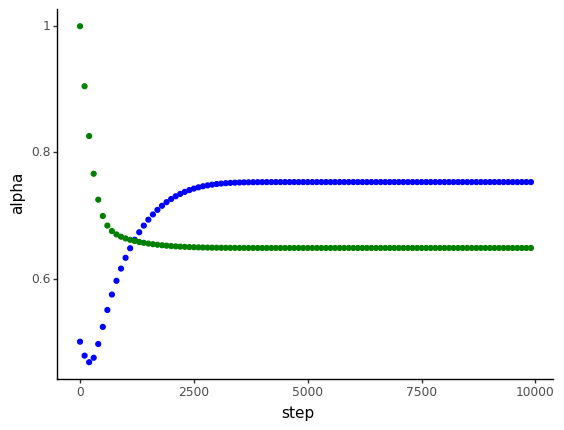

<ggplot: (8789869804055)>

In [84]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='alpha'), color='blue')
 + gg.geom_point(gg.aes(y='beta_div10'), color='green')
 + gg.labs(y='Fitted parameter value')
)

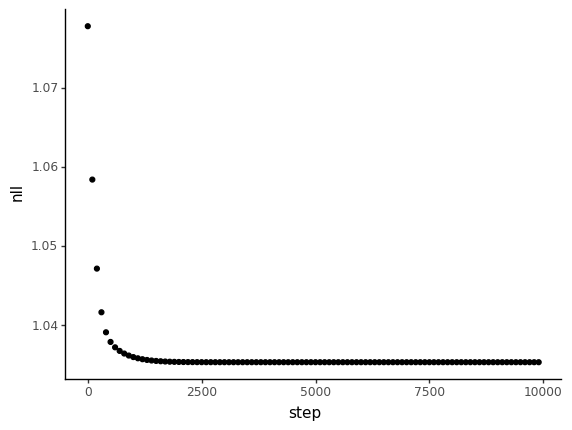

<ggplot: (8789865348928)>

In [85]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='nll'))
)

# (*BONUS*) Improve the model; add forgetting or perseverance as a cognitive process

In [86]:
rl_parameters['fit_forget'] = False
rl_parameters['forget'] = 0.

rl_parameters['fit_persev'] = True
rl_parameters['persev'] = 0.

In [87]:
class RlAbfAgent():
  """Define classic alpha-beta RL model."""

  def __init__(self, n_actions, rl_parameters, init_value=0.5):

    self._n_actions = n_actions
    self._init_value = init_value

    if rl_parameters['fit_alpha']:
      self._alpha = jax.nn.sigmoid(  # 0 < alpha < 1
          hk.get_parameter('unsigmoid_alpha', (1,), init=jnp.zeros)
      )
    else:
      self._alpha = rl_parameters['alpha']

    if rl_parameters['fit_beta']:
      self._beta = 10 * jax.nn.relu(  # 0 < beta < inf
          hk.get_parameter('unrelued_beta_div10', (1,), init=jnp.ones)
      )
    else:
      self._beta = rl_parameters['beta']

    # ============== FILL IN THE BLANKS BELOW ================
    if rl_parameters['fit_forget']:
      self._forget = jax.nn.sigmoid(  # 0 < forget < 1
          hk.get_parameter('unsigmoid_forget', (1,), init=jnp.zeros)
      )
    else:
      self._forget = rl_parameters['forget']

    if rl_parameters['fit_persev']:  # -1 < persev < 1
      self.persev = jax.nn.tanh(
          hk.get_parameter('untanh_persev', (1,), init=jnp.zeros)
      )
    else:
      self.persev = rl_parameters['persev']

  def update_values(self, value, action, reward):
    """SARSA value update."""
    rpe = reward - jnp.sum(action * value, axis=-1)  # shape: (batch_size,)
    new_value = value + action * self._alpha * rpe[:, jnp.newaxis]  # shape: (batch_size, n_actions)

    return new_value

  def calculate_action_probs(self, value):
    return jax.nn.softmax(self._beta * value)  # shape: (batch_size, n_actions)

  def choose_action(self, action_probs):
    return jnp.array([jax.random.choice(next(rng_seq), a=jnp.arange(self._n_actions), p=action_probs[batch]) for batch in range(len(action_probs))])  # shape: (batch_size,)

  # ============== FILL IN THE BLANKS BELOW ================
  def __call__(self, inputs: jnp.array, prev_value: jnp.array):

    action = inputs[:, :self._n_actions]  # shape: (batch_size, n_actions)
    reward = inputs[:, -1]  # shape: (batch_size,)

    # Value update
    new_value = self.update_values(prev_value, action, reward)  # shape: (batch_size, n_actions)

    # # Value forgetting
    # # ============== FILL IN THE BLANKS BELOW ================
    # new_value = (1 - self._forget) * new_value + self._forget * self._init_value

    # Perseverance
    # ============== FILL IN THE BLANKS BELOW ================
    new_value = (1 - self.persev) * new_value + self.persev * action

    # Action selection probabilities
    action_probs = self.calculate_action_probs(new_value)  # shape: shape: (batch_size, n_actions)

    return action_probs, new_value

  def initial_values(self, batch_size):
    return self._init_value * jnp.ones([batch_size, self._n_actions])

In [88]:
def _rlabf_agent_fn(input_seq, return_all_states=False):
  """Cognitive models function."""

  model = RlAbfAgent(n_bandits, rl_parameters)
  batch_size = input_seq.shape[0]
  initial_values = model.initial_values(batch_size)

  return hk.dynamic_unroll(
      model,
      input_seq,
      initial_values,
      time_major=False,
      return_all_states=return_all_states)

In [89]:
@jax.jit
def nll_fn_rlabf(params, key, input_seq):
  """Cross-entropy loss between model-predicted and input behavior."""

  action_probs_seq, _ = rlabf_agent_fn.apply(params, key, input_seq)
  action_probs_seq = (1 - 1e-5) * action_probs_seq + 5e-4  # make sure there are no 0 probabilities

  # calculate NLL (aka cross-entropy)
  action_seq = input_seq[:, :, :n_bandits]
  nll = -jnp.sum(jnp.log(action_probs_seq[:, :-1]) * action_seq[:, 1:]) / batch_size / n_trials

  return nll

In [90]:
@jax.jit
def update_func_rlabf(params, key, opt_state, input_seq):
  """Updates function for the RNN."""

  nll, grads = jax.value_and_grad(nll_fn_rlabf)(params, key, input_seq)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  scalars = {'nll': [nll]}

  # Track fitted parameter values
  if '~' in params.keys():
    for p_rnn in params['~'].keys():
      scalars.update({p_rnn: [params['~'][p_rnn][0]]})

  return new_params, new_opt_state, scalars

In [91]:
input_seq = human_data[['action_{}'.format(i) for i in range(n_bandits)] + ['reward_01']]
input_seq = input_seq.values.reshape([batch_size, n_trials, n_bandits + 1])
# input_seq

In [92]:
rlabf_agent_fn = hk.transform(_rlabf_agent_fn)
params_rlabf = rlabf_agent_fn.init(next(rng_seq), input_seq)
opt_state = init_opt(params_rlabf)
params_rlabf

{'~': {'unsigmoid_alpha': Array([0.], dtype=float32),
  'unrelued_beta_div10': Array([1.], dtype=float32),
  'untanh_persev': Array([0.], dtype=float32)}}

In [93]:
init_nll = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-init_nll)}%')

Average trialwise probability of initial model to act like humans: 34.0367317199707%


In [94]:
all_scalars = pd.DataFrame()

for current_step in range(n_training_steps):

  params_rlabf, opt_state, scalars = update_func_rlabf(
      params_rlabf, next(rng_seq), opt_state, input_seq)
  nll = nll_fn_rlabf(
      params_rlabf, next(rng_seq), input_seq)

  if current_step % 1000 == 0:
    print(f'Step {current_step}: nll = {nll}')

    # Update and save scalars
    scalars.update({'step': [current_step]})
    all_scalars = pd.concat([all_scalars, pd.DataFrame(scalars)])

Step 0: nll = 1.0621672868728638
Step 1000: nll = 0.93600994348526
Step 2000: nll = 0.9359868764877319
Step 3000: nll = 0.9359868764877319
Step 4000: nll = 0.9359868168830872
Step 5000: nll = 0.9359868764877319
Step 6000: nll = 0.9359869360923767
Step 7000: nll = 0.9359868168830872
Step 8000: nll = 0.9359868168830872
Step 9000: nll = 0.9359869360923767


In [95]:
final_nll = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-final_nll)}%')

Average trialwise probability of initial model to act like humans: 39.21986520290375%


In [96]:
all_scalars.reset_index(drop=True, inplace=True)

for col in all_scalars.columns:
  all_scalars[col] = all_scalars[col].astype(float)

all_scalars['alpha'] = jax.nn.sigmoid(jnp.array(all_scalars['unsigmoid_alpha']))
# all_scalars['forget'] = jax.nn.sigmoid(jnp.array(all_scalars['unsigmoid_forget']))
all_scalars['persev'] = jax.nn.tanh(jnp.array(all_scalars['untanh_persev']))
all_scalars['beta_div10'] = jax.nn.relu(jnp.array(all_scalars['unrelued_beta_div10']))

best_rlabf = all_scalars.iloc[-1]

all_scalars

,nll,unrelued_beta_div10,unsigmoid_alpha,untanh_persev,step,alpha,persev,beta_div10
0,1.077730,1.000000,0.000000,0.000000,0.0,0.500000,0.000000,1.000000
1,0.936010,0.518420,-0.431369,0.035850,1000.0,0.393800,0.035835,0.518420
2,0.935987,0.512993,-0.469829,0.036627,2000.0,0.384657,0.036611,0.512993
3,0.935987,0.512992,-0.469876,0.036627,3000.0,0.384646,0.036611,0.512992
4,0.935987,0.512992,-0.469877,0.036627,4000.0,0.384645,0.036611,0.512992
5,0.935987,0.512992,-0.469878,0.036627,5000.0,0.384645,0.036611,0.512992
6,0.935987,0.512993,-0.469879,0.036627,6000.0,0.384645,0.036611,0.512993
7,0.935987,0.512993,-0.469878,0.036627,7000.0,0.384645,0.036611,0.512993
8,0.935987,0.512993,-0.469878,0.036627,8000.0,0.384645,0.036611,0.512993
9,0.935987,0.512993,-0.469878,0.036627,9000.0,0.384645,0.036611,0.512993


In [97]:
best_rl_parameters

{'alpha': 0.6, 'beta': 7.0}

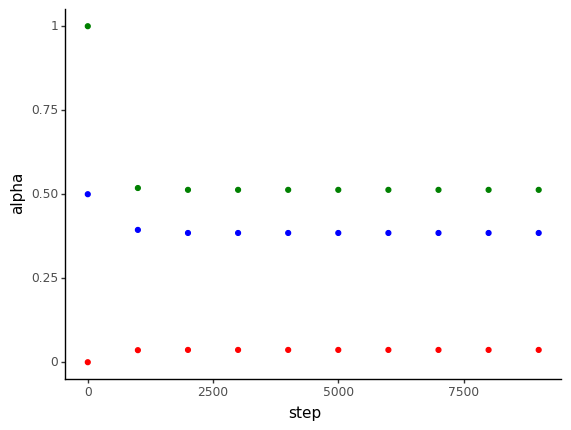

<ggplot: (8789874266479)>

In [98]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='alpha'), color='blue')
 + gg.geom_point(gg.aes(y='beta_div10'), color='green')
 + gg.geom_point(gg.aes(y='persev'), color='red')
 + gg.labs(y='Fitted parameter values')
#  + gg.geom_point(gg.aes(y='forget'), color='red')
)

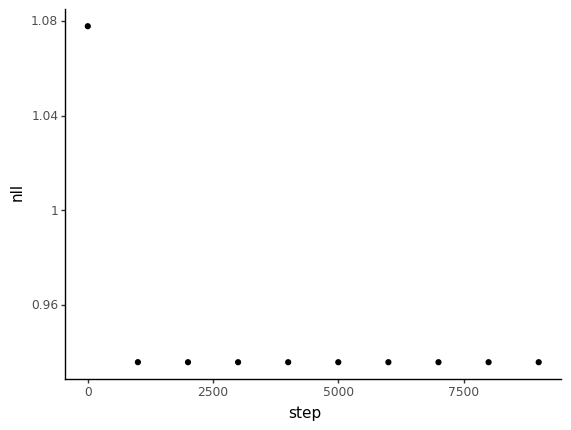

<ggplot: (8789873799271)>

In [99]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='nll'))
)

In [100]:
aic_rlab = 2 * best_rlab['nll'] * n_trials + 2 * 2
aic_rlabf = 2 * best_rlabf['nll'] * n_trials + 2 * 3

print(f'AIC for rlab: {aic_rlab}')
print(f'AIC for rlabf: {aic_rlabf}')

AIC for rlab: 314.61153411865234
AIC for rlabf: 286.796080827713


# (*Bonus*): Fit a neural network to human behavior

In [101]:
class LstmAgent(hk.RNNCore):
  """LSTM that predicts action logits based on all inputs (action, reward)."""

  def __init__(self, n_hiddens, n_bandits):

    super().__init__()

    self._hidden_size = n_hiddens
    self._n_actions = n_bandits

  def __call__(self, inputs: jnp.array, prev_state):

    hidden_state, cell_state = prev_state

    forget_gate = jax.nn.sigmoid(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )

    input_gate = jax.nn.sigmoid(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )

    candidates = jax.nn.tanh(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )

    next_cell_state = forget_gate * cell_state + input_gate * candidates

    output_gate = jax.nn.sigmoid(
        hk.Linear(self._hidden_size, with_bias=False)(inputs)
        + hk.Linear(self._hidden_size)(hidden_state)
    )
    next_hidden_state = output_gate * jax.nn.tanh(next_cell_state)

    action_probs = jax.nn.softmax(
        hk.Linear(self._n_actions)(next_hidden_state))  # (batch_size, n_act)

    return action_probs, (next_hidden_state, next_cell_state)

  def initial_state(self, batch_size):

    return (jnp.zeros((batch_size, self._hidden_size)),  # hidden_state
            jnp.zeros((batch_size, self._hidden_size)))  # cell_state

In [102]:
def _lstm_fn(input_seq, return_all_states=False):
  """Cognitive models function."""

  model = LstmAgent(n_hiddens=5, n_bandits=n_bandits)

  batch_size = input_seq.shape[0]
  initial_state = model.initial_state(batch_size)

  return hk.dynamic_unroll(
      model,
      input_seq,
      initial_state,
      time_major=False,
      return_all_states=return_all_states)

In [103]:
@jax.jit
def nll_fn_lstm(params, key, input_seq):
  """Cross-entropy loss between model-predicted and input behavior."""

  # input_seq = jnp.concatenate([action_seq, reward_seq], axis=-1)
  action_probs_seq, _ = lstm_fn.apply(params, key, input_seq)
  # make sure there are no 0 probabilities
  action_probs_seq = (1 - 1e-5) * action_probs_seq + 5e-4

  # calculate loss (NLL aka cross-entropy)
  # "sum" and not "mean" so that missed trials don't influence the results
  action_seq = input_seq[:, :, :n_bandits]
  nll = -jnp.sum(jnp.log(action_probs_seq[:, :-1]) * action_seq[:, 1:]) / batch_size / n_trials

  return nll

In [104]:
@jax.jit
def update_func(params, key, opt_state, input_seq):
  """Updates function for the RNN."""

  nll, grads = jax.value_and_grad(nll_fn_lstm)(params, key, input_seq)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  scalars = {'nll': [nll]}

  # Track fitted parameter values
  if '~' in params.keys():
    for p_rnn in params['~'].keys():
      scalars.update({p_rnn: [params['~'][p_rnn][0]]})

  return new_params, new_opt_state, scalars

In [105]:
lstm_fn = hk.transform(_lstm_fn)
params_lstm = lstm_fn.init(next(rng_seq), input_seq)
opt_state = init_opt(params_lstm)
params_lstm

{'lstm_agent/linear': {'w': Array([[-0.673001  , -0.59143466, -0.43035308,  0.08913811,  0.2788586 ],
         [-0.00363045, -0.3502626 ,  0.4973475 , -0.0288186 , -0.0727029 ],
         [-0.24979374, -0.44321752, -0.15771593, -0.7127624 ,  0.6685362 ],
         [ 0.16446382, -0.08238235, -0.2885374 , -0.4927662 , -0.47701403],
         [ 0.19319692,  0.18105987,  0.33508733,  0.60856926,  0.5238726 ]],      dtype=float32)},
 'lstm_agent/linear_1': {'w': Array([[ 0.36843103, -0.55090046,  0.68811333, -0.1226547 ,  0.82434314],
         [ 0.25001514,  0.39853102, -0.29437038,  0.27668396,  0.17009339],
         [-0.39946234,  0.18118516,  0.58972996, -0.4242388 ,  0.41969422],
         [-0.3988393 , -0.4138076 , -0.01317737, -0.64658076,  0.12964246],
         [-0.31257856, -0.00545877,  0.07471452,  0.19513138,  0.1236653 ]],      dtype=float32),
  'b': Array([0., 0., 0., 0., 0.], dtype=float32)},
 'lstm_agent/linear_2': {'w': Array([[ 0.47467846, -0.73973835, -0.25093073, -0.13188893,

In [106]:
init_nll = nll_fn_lstm(params_lstm, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-init_nll)}%')

Average trialwise probability of initial model to act like humans: 27.050718665122986%


In [107]:
all_scalars = pd.DataFrame()

for current_step in range(n_training_steps):

  params_lstm, opt_state, scalars = update_func(
      params_lstm, next(rng_seq), opt_state, input_seq)
  nll = nll_fn_lstm(
      params_lstm, next(rng_seq), input_seq)

  if current_step % 100 == 0:
    print(f'Step {current_step}: nll = {nll}')

    # Update and save scalars
    scalars.update({'step': [current_step]})
    all_scalars = pd.concat([all_scalars, pd.DataFrame(scalars)])

Step 0: nll = 1.3059308528900146
Step 100: nll = 1.162240743637085
Step 200: nll = 1.0278356075286865
Step 300: nll = 0.9834731817245483
Step 400: nll = 0.9700639843940735
Step 500: nll = 0.9596767425537109
Step 600: nll = 0.9503594040870667
Step 700: nll = 0.9425327181816101
Step 800: nll = 0.9365537762641907
Step 900: nll = 0.9320896863937378
Step 1000: nll = 0.928342342376709
Step 1100: nll = 0.9247897863388062
Step 1200: nll = 0.9213002324104309
Step 1300: nll = 0.9178224205970764
Step 1400: nll = 0.9142233729362488
Step 1500: nll = 0.9102903008460999
Step 1600: nll = 0.9060416221618652
Step 1700: nll = 0.9021002650260925
Step 1800: nll = 0.8984882235527039
Step 1900: nll = 0.8950549364089966
Step 2000: nll = 0.8918357491493225
Step 2100: nll = 0.8889263868331909
Step 2200: nll = 0.8863240480422974
Step 2300: nll = 0.8839516639709473
Step 2400: nll = 0.8817259669303894
Step 2500: nll = 0.8795692920684814
Step 2600: nll = 0.8774093985557556
Step 2700: nll = 0.875167727470398
Step 28

In [108]:
final_nll = nll_fn_lstm(params_lstm, next(rng_seq), input_seq)
print(f'Average trialwise probability of initial model to act like humans: {100 * np.exp(-final_nll)}%')

Average trialwise probability of initial model to act like humans: 44.00208592414856%


In [109]:
all_scalars.reset_index(drop=True, inplace=True)

for col in all_scalars.columns:
  all_scalars[col] = all_scalars[col].astype(float)

best_lstm = all_scalars.iloc[-1]

all_scalars

,nll,step
0,1.307457,0.0
1,1.163727,100.0
2,1.028762,200.0
3,0.983661,300.0
4,0.970174,400.0
...,...,...
95,0.821691,9500.0
96,0.821499,9600.0
97,0.821365,9700.0
98,0.821204,9800.0


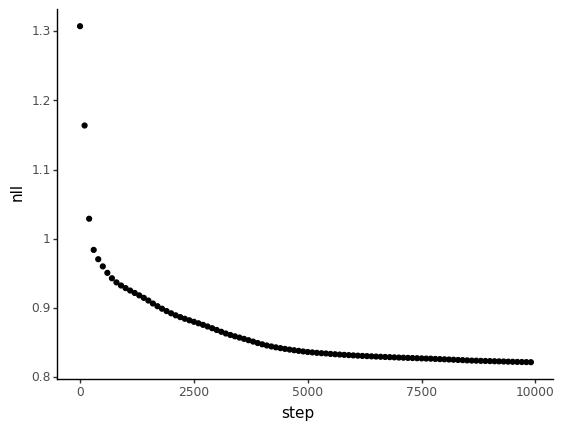

<ggplot: (8789857728708)>

In [110]:
(gg.ggplot(all_scalars, gg.aes(x='step'))
 + gg.geom_point(gg.aes(y='nll'))
)

Problem: We can't calculate AIC here -> need to do test data.

In [112]:
# # Option 1
# test_data = pd.read_csv("./bahrami_200.csv")

# Option 2 (in case option 1 doesn't work)
from google.colab import files
import io
uploaded = files.upload()
test_data = pd.read_csv(io.BytesIO(uploaded['bahrami_200.csv']))

test_data

Saving bahrami_200.csv to bahrami_200.csv


,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed
0,100,1.0,87.0,1446.0,84,87,42,23,0,False
1,100,1.0,90.0,1597.0,90,90,46,18,1,False
2,100,3.0,28.0,1216.0,80,84,53,28,2,False
3,100,2.0,50.0,1036.0,87,81,50,24,3,False
4,100,1.0,92.0,1094.0,86,92,61,28,4,False
...,...,...,...,...,...,...,...,...,...,...
14995,199,3.0,48.0,601.0,47,35,62,48,145,False
14996,199,2.0,61.0,652.0,46,47,61,57,146,False
14997,199,2.0,70.0,565.0,46,35,70,43,147,False
14998,199,2.0,60.0,624.0,46,44,60,59,148,False


In [113]:
# Let's first add a separate "one-hot" column for each action that indicates of this action was chosen on this trial or not
action_cols = ['action_{}'.format(i) for i in range(n_bandits)]
test_data[action_cols] = jax.nn.one_hot(jnp.array(test_data['action']), n_bandits)
test_data

,participant_id,action,reward,response_time,reward_action0,reward_action1,reward_action2,reward_action3,trial_id,missed,action_0,action_1,action_2,action_3
0,100,1.0,87.0,1446.0,84,87,42,23,0,False,0.0,1.0,0.0,0.0
1,100,1.0,90.0,1597.0,90,90,46,18,1,False,0.0,1.0,0.0,0.0
2,100,3.0,28.0,1216.0,80,84,53,28,2,False,0.0,0.0,0.0,1.0
3,100,2.0,50.0,1036.0,87,81,50,24,3,False,0.0,0.0,1.0,0.0
4,100,1.0,92.0,1094.0,86,92,61,28,4,False,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,199,3.0,48.0,601.0,47,35,62,48,145,False,0.0,0.0,0.0,1.0
14996,199,2.0,61.0,652.0,46,47,61,57,146,False,0.0,0.0,1.0,0.0
14997,199,2.0,70.0,565.0,46,35,70,43,147,False,0.0,0.0,1.0,0.0
14998,199,2.0,60.0,624.0,46,44,60,59,148,False,0.0,0.0,1.0,0.0


In [114]:
input_seq_test = test_data[['action_{}'.format(i) for i in range(n_bandits)] + ['reward']]
input_seq_test['reward'] /= 100
input_seq_test = input_seq_test.values.reshape([batch_size, n_trials, n_bandits + 1])
input_seq_test

<ipython-input-114-6c1827451046>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([[[0.  , 1.  , 0.  , 0.  , 0.87],
        [0.  , 1.  , 0.  , 0.  , 0.9 ],
        [0.  , 0.  , 0.  , 1.  , 0.28],
        ...,
        [0.  , 1.  , 0.  , 0.  , 0.35],
        [0.  , 0.  , 1.  , 0.  , 0.6 ],
        [0.  , 0.  , 1.  , 0.  , 0.56]],

       [[0.  , 1.  , 0.  , 0.  , 0.87],
        [0.  , 1.  , 0.  , 0.  , 0.9 ],
        [0.  , 0.  , 0.  , 1.  , 0.28],
        ...,
        [0.  , 1.  , 0.  , 0.  , 0.35],
        [0.  , 0.  , 1.  , 0.  , 0.6 ],
        [0.  , 0.  , 1.  , 0.  , 0.56]],

       [[0.  , 1.  , 0.  , 0.  , 0.87],
        [0.  , 0.  , 1.  , 0.  , 0.46],
        [1.  , 0.  , 0.  , 0.  , 0.8 ],
        ...,
        [1.  , 0.  , 0.  , 0.  , 0.46],
        [0.  , 1.  , 0.  , 0.  , 0.44],
        [0.  , 1.  , 0.  , 0.  , 0.35]],

       ...,

       [[0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  ],
        [1.  , 0.  , 0.  , 0.  , 0.8 ],
        ...,
        [0.  , 0.  , 0.  , 1.  , 0.43],
        [0.  , 0.  , 1.  , 0.  , 0.6 ],
        [

In [115]:
train_nll_rlab = nll_fn_rlab(params_rlab, next(rng_seq), input_seq)
train_nll_rlabf = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq)
train_nll_lstm = nll_fn_lstm(params_lstm, next(rng_seq), input_seq)

print(f'RLab prediction accuracy on training data: {100 * np.exp(-train_nll_rlab)}%')
print(f'RLabf prediction accuracy on training data: {100 * np.exp(-train_nll_rlabf)}%')
print(f'LSTM prediction accuracy on training data: {100 * np.exp(-train_nll_lstm)}%')

test_nll_rlab = nll_fn_rlab(params_rlab, next(rng_seq), input_seq_test)
test_nll_rlabf = nll_fn_rlabf(params_rlabf, next(rng_seq), input_seq_test)
test_nll_lstm = nll_fn_lstm(params_lstm, next(rng_seq), input_seq_test)

print(f'\nRLab prediction accuracy on held-out data: {100 * np.exp(-test_nll_rlab)}%')
print(f'RLabf prediction accuracy on held-out data: {100 * np.exp(-test_nll_rlabf)}%')
print(f'LSTM prediction accuracy on held-out data: {100 * np.exp(-test_nll_lstm)}%')

RLab prediction accuracy on training data: 35.5094313621521%
RLabf prediction accuracy on training data: 39.21986520290375%
LSTM prediction accuracy on training data: 44.00208592414856%

RLab prediction accuracy on held-out data: 37.87238001823425%
RLabf prediction accuracy on held-out data: 39.86006677150726%
LSTM prediction accuracy on held-out data: 43.009430170059204%
